In [1]:
import os
import sys
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras import mixed_precision

from utils.label_utils import get_labels, get_train_labels
from models.u2net import U2NET, U2NET_lite
from models.unet import unet, unet_small
from models.deeplabv3_xception import deeplabv3

physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
K.clear_session()

def enable_amp():
    mixed_precision.set_global_policy("mixed_float16")
    
print("Tensorflow version: ", tf.__version__)
print(physical_devices,"\n")
enable_amp()

Tensorflow version:  2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [2]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

In [3]:
def read_tfrecord(serialized_example):
    feature_description = {
        'image': tf.io.FixedLenFeature((), tf.string),
        'segmentation': tf.io.FixedLenFeature((), tf.string),
        'height': tf.io.FixedLenFeature((), tf.int64),
        'width': tf.io.FixedLenFeature((), tf.int64),
        'image_depth': tf.io.FixedLenFeature((), tf.int64),
        'mask_depth': tf.io.FixedLenFeature((), tf.int64),
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    image = tf.io.parse_tensor(example['image'], out_type = tf.uint8)
    image_shape = [example['height'], example['width'], 3]
    image = tf.reshape(image, image_shape)
    mask = tf.io.parse_tensor(example['segmentation'], out_type = tf.uint8)
    mask_shape = [example['height'], example['width'], 1]
    mask = tf.reshape(mask, mask_shape)
    return image, mask


def get_dataset_from_tfrecord(tfrecord_dir):
    tfrecord_dataset = tf.data.TFRecordDataset(tfrecord_dir)
    parsed_dataset = tfrecord_dataset.map(read_tfrecord)
    return parsed_dataset

In [4]:
train_tfrecord_dir = 'records/fine_train.tfrecords'
test_tfrecord_dir = 'records/fine_test.tfrecords'

img_height = 256
img_width = 512
n_classes = 19

labels = get_train_labels()
id2label = { label.id : label for label in labels }
trainId2label = { label.trainId : label for label in labels }

In [5]:
@tf.function
def mask_to_categorical(image, mask):
    mask = tf.squeeze(mask)
    mask = tf.one_hot(tf.cast(mask, tf.int32), n_classes)
    mask = tf.cast(mask, tf.float32)
    return image, mask


@tf.function
def load_image_train(input_image, input_mask):
    input_image = tf.image.resize(input_image, (img_height, img_width))
    input_mask = tf.image.resize(input_mask, (img_height, img_width))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_image, input_mask = mask_to_categorical(input_image, input_mask)
    input_mask = tf.squeeze(input_mask)

    return input_image, input_mask


def load_image_test(input_image, input_mask):
    input_image = tf.image.resize(input_image, (img_height, img_width))
    input_mask = tf.image.resize(input_mask, (img_height, img_width))
    
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_image, input_mask = mask_to_categorical(input_image, input_mask)
    input_mask = tf.squeeze(input_mask)

    return input_image, input_mask

In [6]:
TRAIN_LENGTH = 2780
TEST_LENGTH = 695
BATCH_SIZE = 4
BUFFER_SIZE = 1000

In [7]:
train_tfrecords_dataset = get_dataset_from_tfrecord(train_tfrecord_dir)
test_tfrecords_dataset = get_dataset_from_tfrecord(test_tfrecord_dir)

In [8]:
# Preprocessing: resize the images and masks, flip them, 
train = train_tfrecords_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_tfrecords_dataset.map(load_image_test)

In [9]:
train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [10]:
def label_to_rgb(mask):
    mask_rgb = np.zeros((img_height, img_width, 3), dtype=np.uint8)
    for i in range(0,n_classes):
        mask_rgb[mask[:,:,0]==i] = trainId2label[i].color
        #mask_rgb[mask[:,:,0]==i] = id2label[i].color
    return mask_rgb


def display(display_list, title=False):
    plt.figure(figsize=(14, 21))
    # plt.figure(figsize=(6, 9))
    if title:
        title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(len(display_list), 1, i+1)
        if title:
            plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

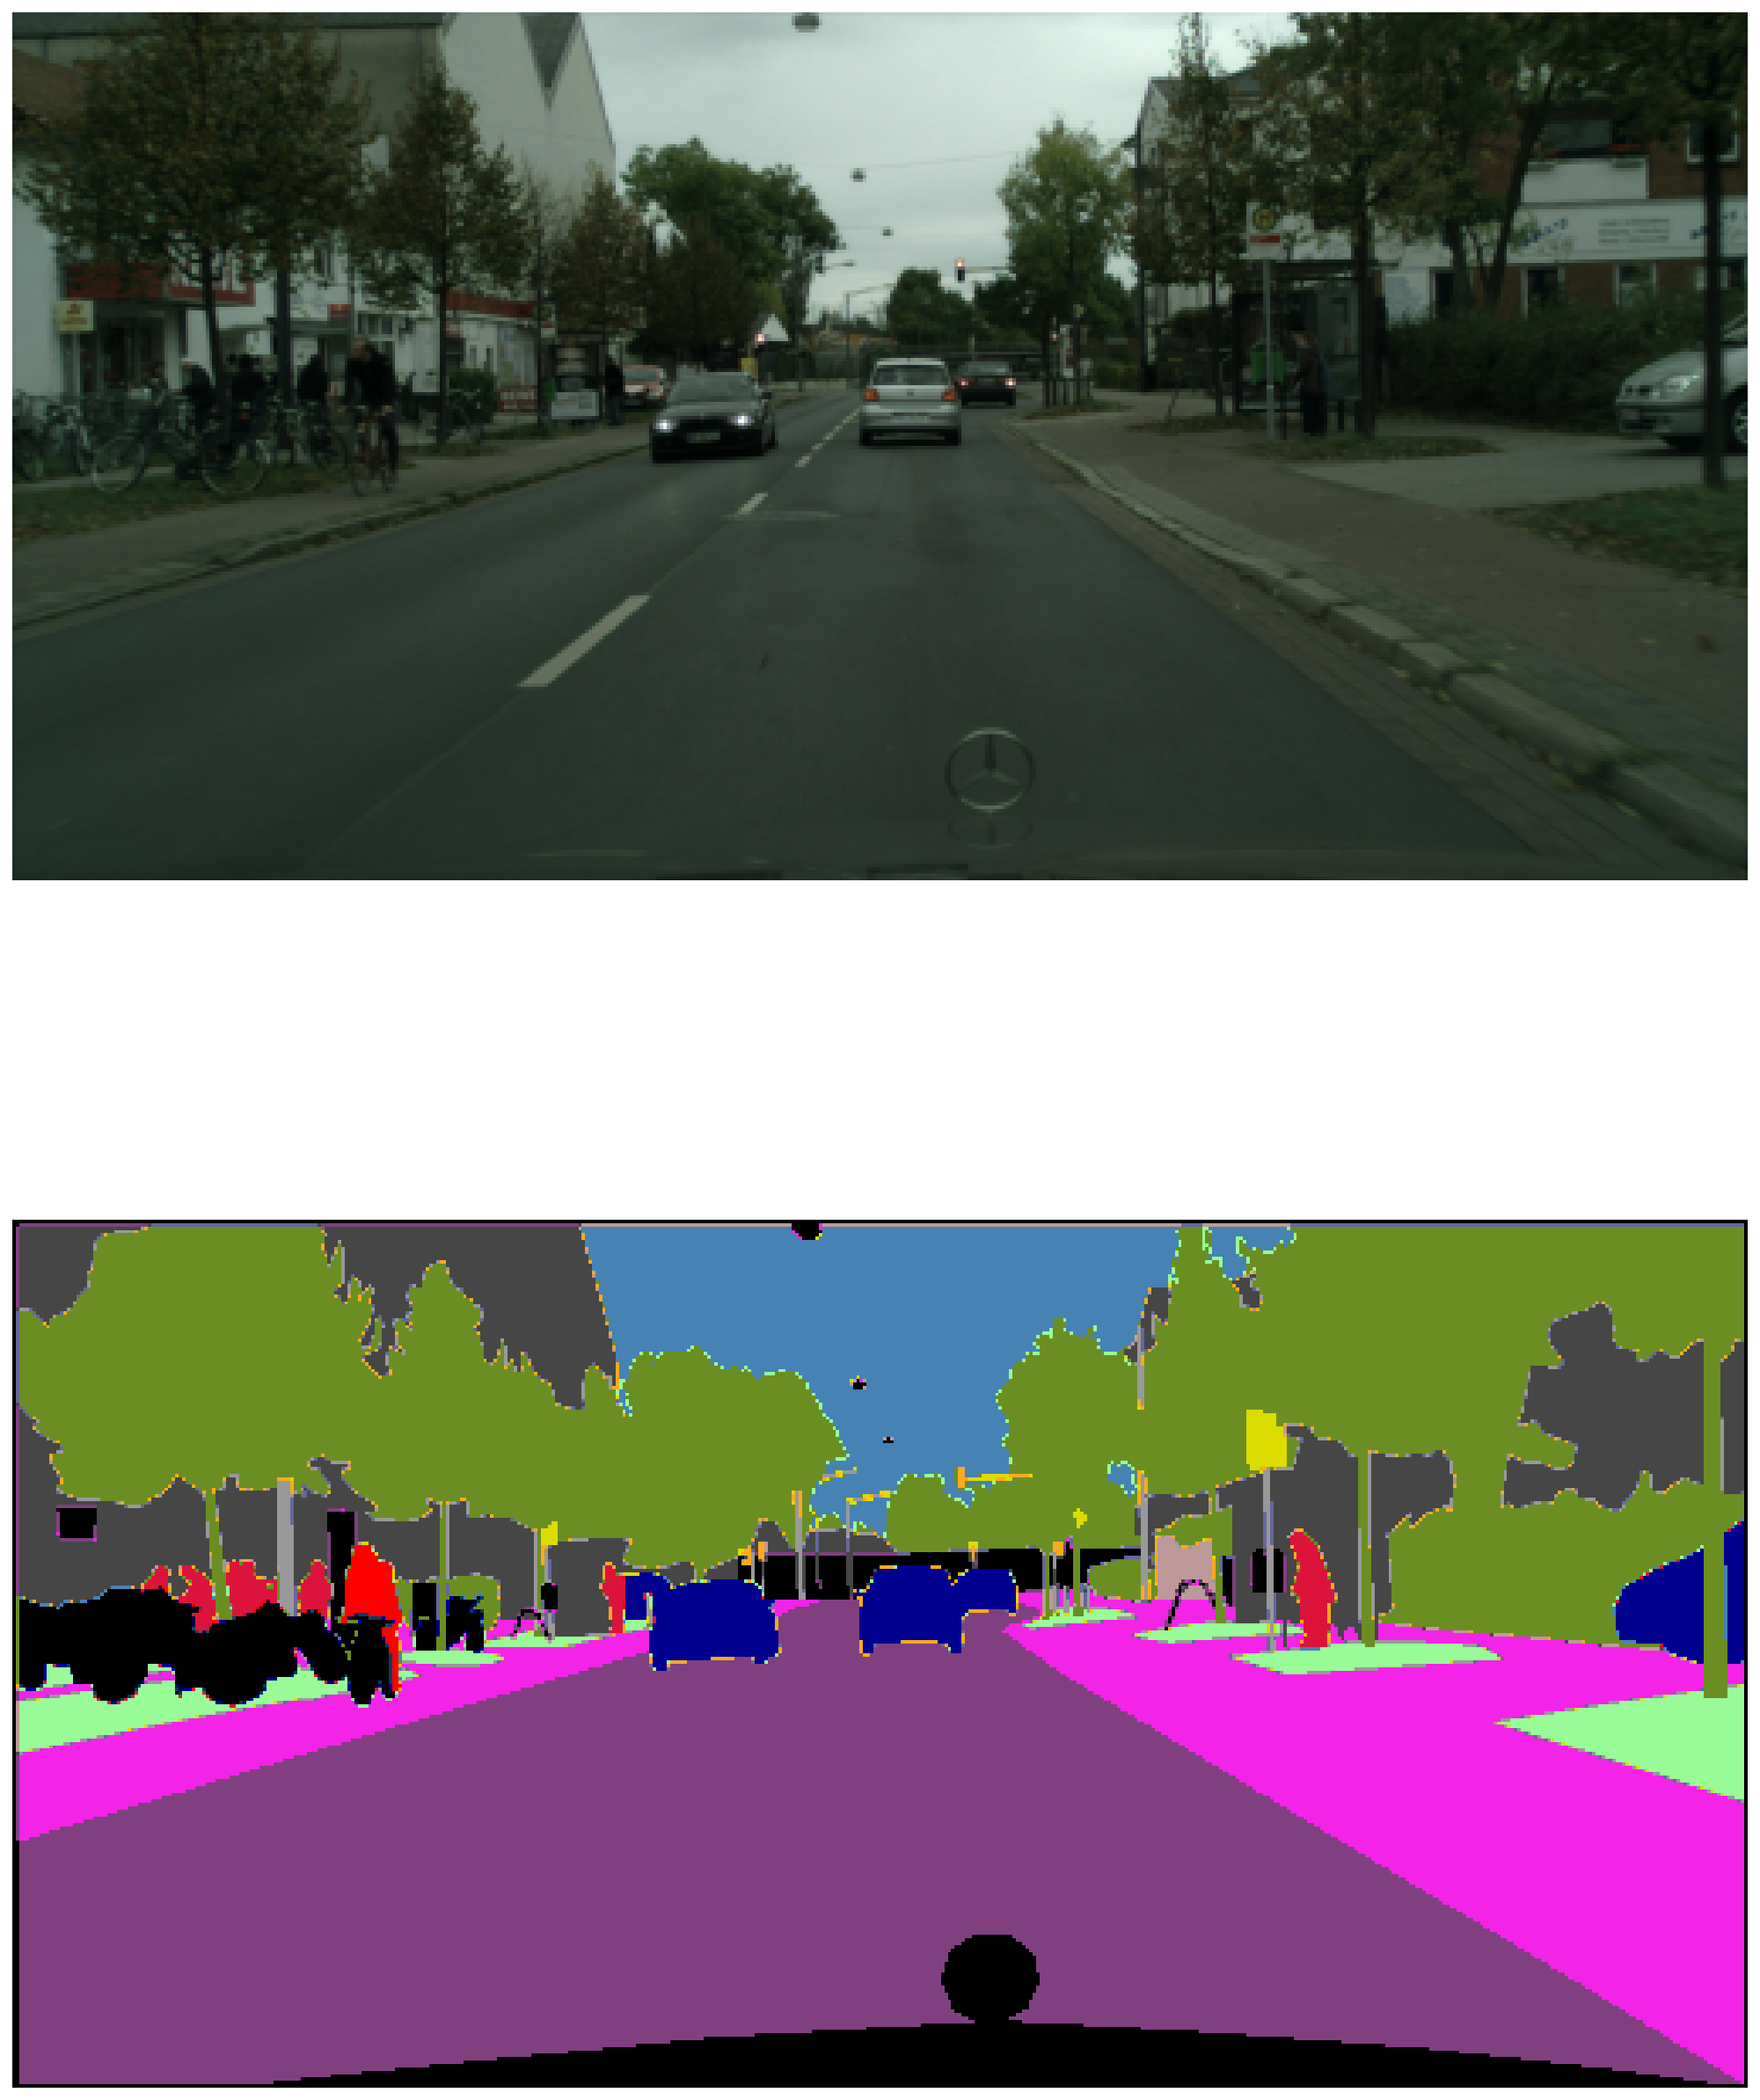

In [11]:
for image, mask in test.take(11):
    sample_image, sample_mask = image, mask
    
sample_mask = tf.argmax(sample_mask, axis=-1)
sample_mask = sample_mask[..., tf.newaxis]
sample_mask = label_to_rgb(sample_mask.numpy())

display([sample_image, sample_mask])

In [12]:
def iou_coef(y_true, y_pred):
    """When smooth=1, metrics where absent classes contribute to the class mean as 1.0. 
       Road is trainId == 0, but "unlabeled" is Id == 0. So start from zero when training with trainId
       intersection and union shapes are batch_size * n_classes (values = area in pixels)"""
    smooth = 1.0
    intersection = K.sum(y_true * y_pred, axis=(1,2))
    mask_sum = K.sum(y_true, axis=(1,2)) + K.sum(y_pred, axis=(1,2))
    union = mask_sum - intersection
    iou = K.mean((intersection + smooth) / (union + smooth))
    return iou


def cce_iou_loss(y_true, y_pred):
    return (tf.keras.losses.categorical_crossentropy(y_true, y_pred) - iou_coef(y_true, y_pred)) + 1

In [13]:
K.clear_session()
# model = unet(input_height=img_height, input_width=img_width, n_classes=n_classes, act="selu")
# model = unet_small(input_height=img_height, input_width=img_width, n_classes=n_classes, act="relu")
model = U2NET(input_height=img_height, input_width=img_width, n_classes=n_classes)
# model = U2NET_lite(input_height=img_height, input_width=img_width, n_classes=n_classes)
# model = deeplabv3(input_height=img_height, input_width=img_width, n_classes=n_classes)

In [14]:
u2net_model = True

In [15]:
def create_mask(pred_mask):
    pred_mask = tf.squeeze(pred_mask)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = label_to_rgb(pred_mask.numpy())
    return pred_mask


def show_predictions(u2net=False):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    if u2net:
        pred_mask = pred_mask[0]
    display([sample_image, sample_mask, create_mask(pred_mask)])

        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(u2net=u2net_model)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

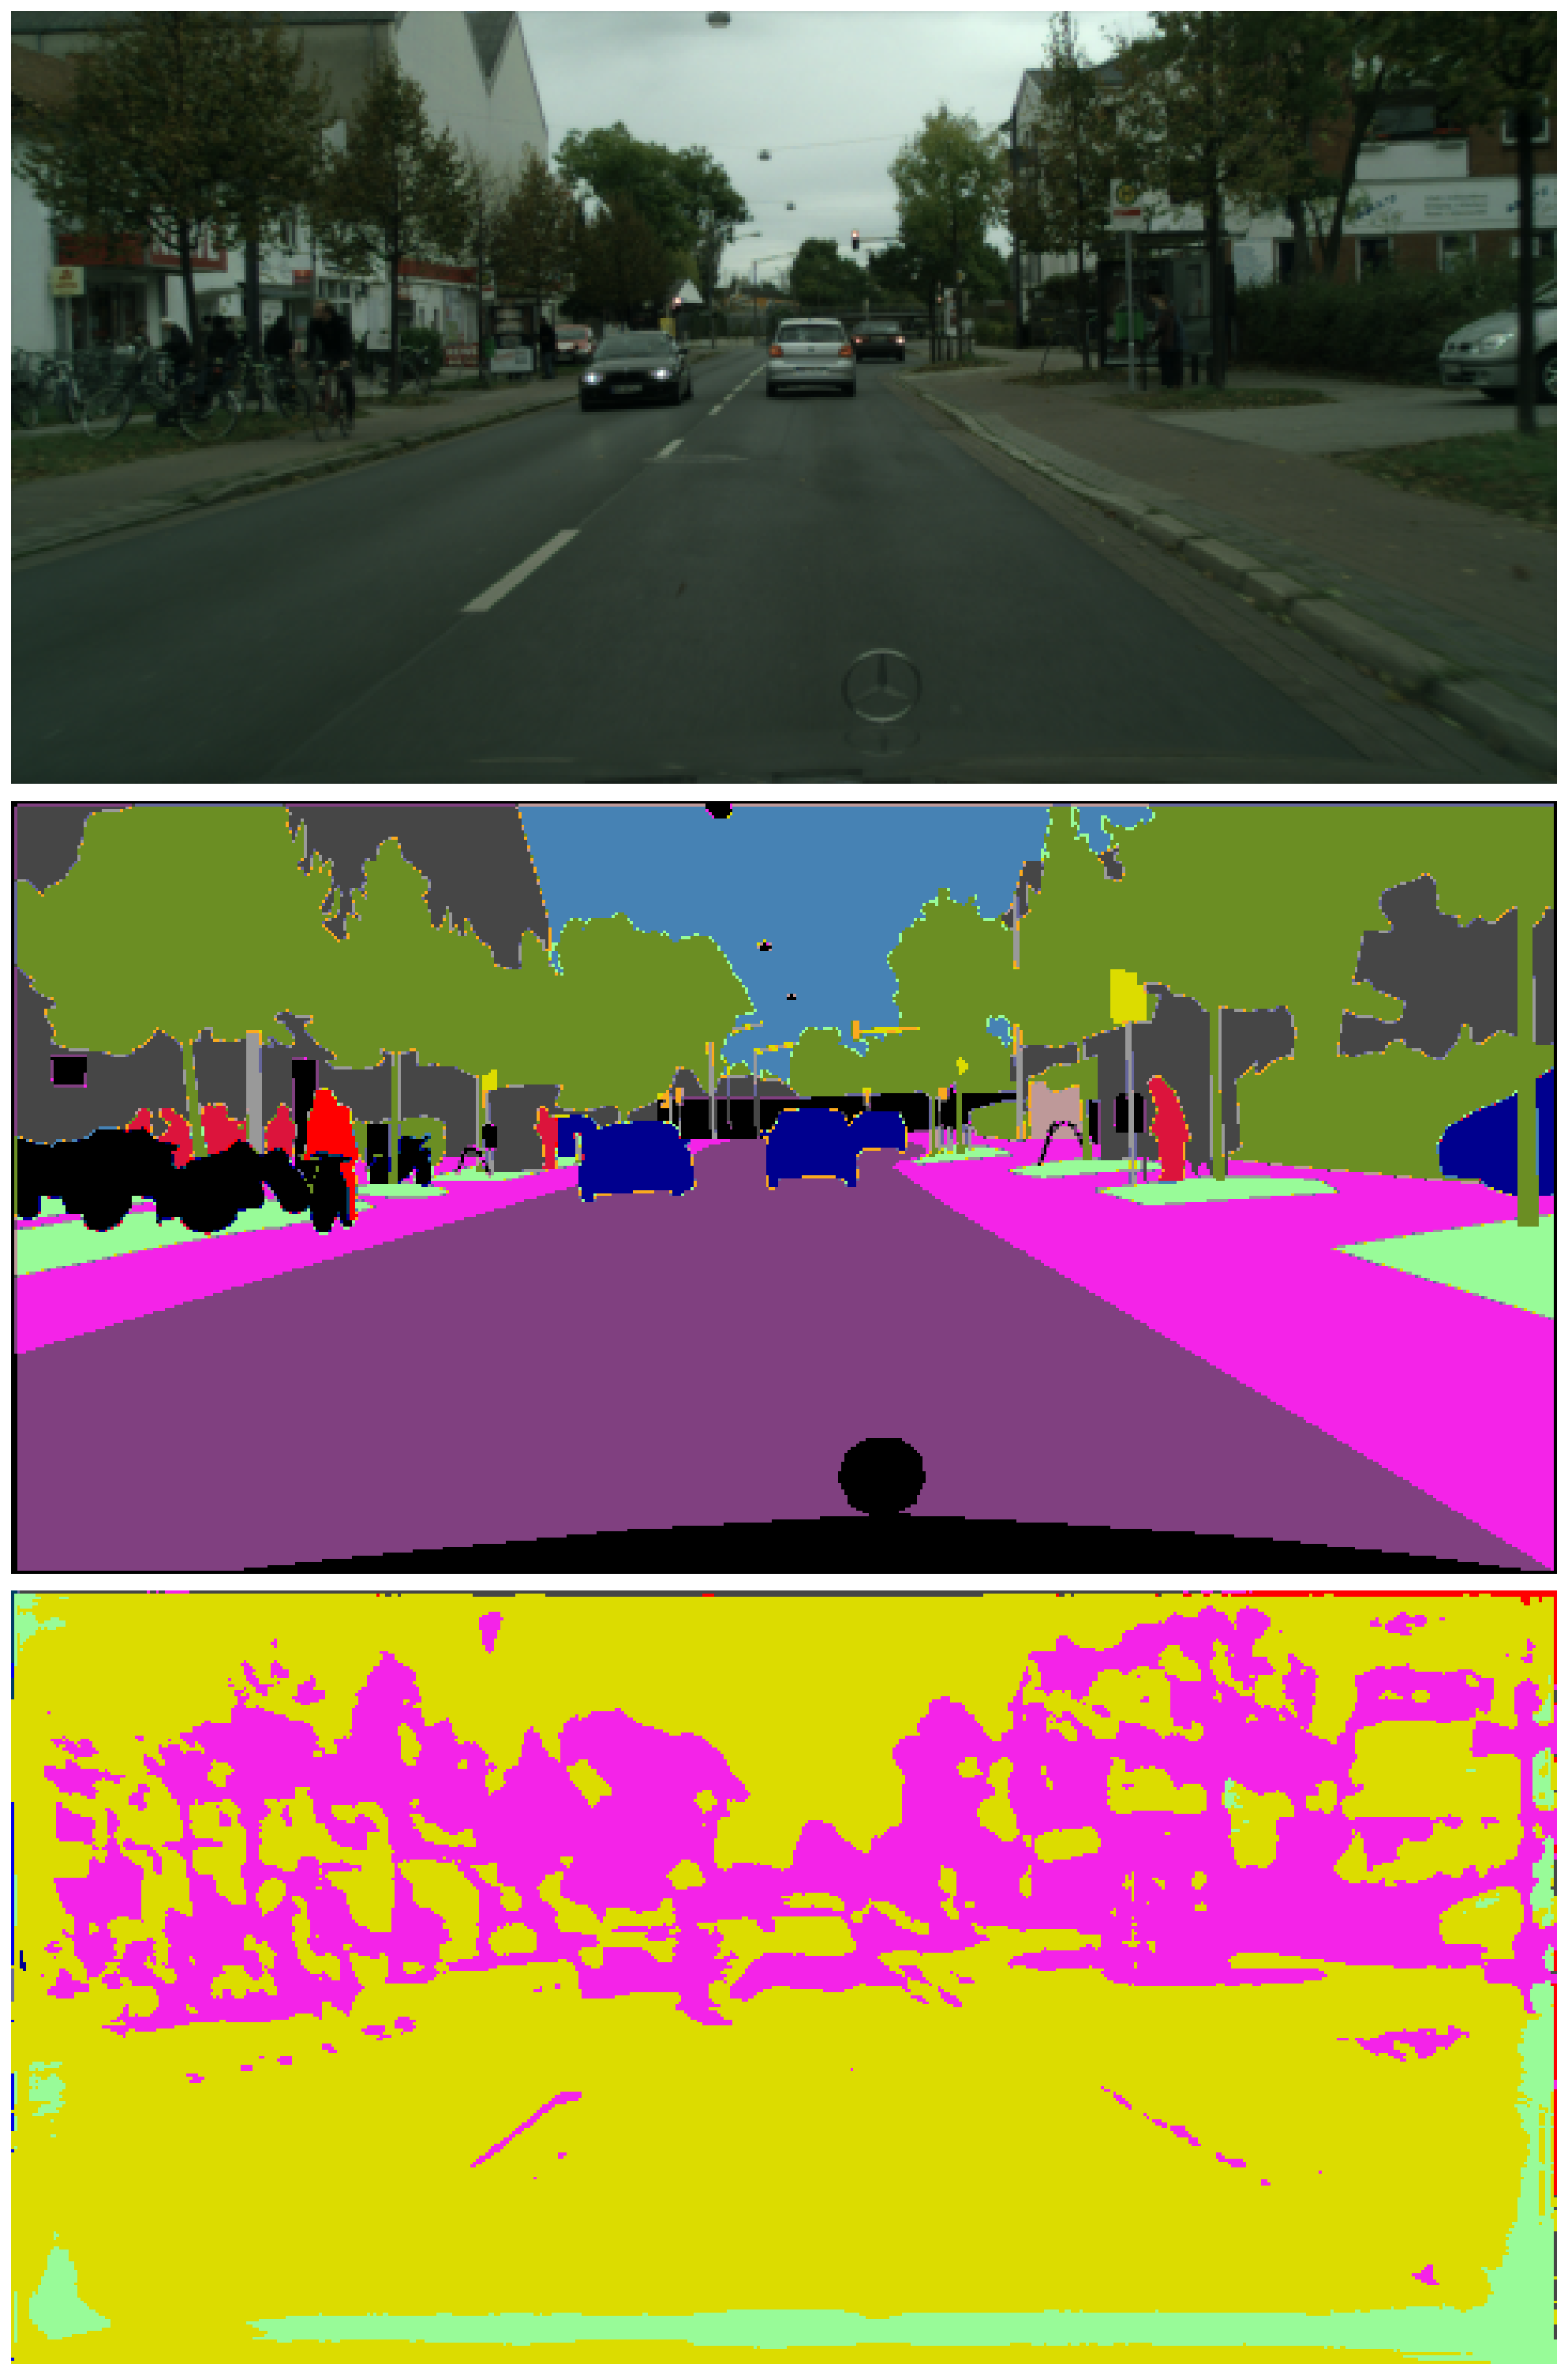

In [16]:
show_predictions(u2net=u2net_model)

In [17]:
model.compile(
    optimizer = Adam(lr=1e-4),
    loss = cce_iou_loss, 
    metrics = ['accuracy', iou_coef]
)

In [18]:
callbacks = [
    DisplayCallback(),
    EarlyStopping(monitor='val_loss', mode='min', patience=6, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.1, min_lr=1e-10, verbose=1),
]

In [19]:
EPOCHS = 10
SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE // SUBSPLITS
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // SUBSPLITS

In [ ]:
results = model.fit(
    train_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs = (EPOCHS*SUBSPLITS),
    validation_data = test_dataset,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/50
139/139 [==============================] - ETA: 0s - loss: 20.1752 - d0_loss: 2.7298 - d1_loss: 3.1965 - d2_loss: 2.8880 - d3_loss: 3.0464 - d4_loss: 2.7876 - d5_loss: 2.7569 - d6_loss: 2.7700 - d0_accuracy: 0.4986 - d0_iou_coef: 0.0926 - d1_accuracy: 0.4058 - d1_iou_coef: 0.0668 - d2_accuracy: 0.4540 - d2_iou_coef: 0.0726 - d3_accuracy: 0.4597 - d3_iou_coef: 0.0852 - d4_accuracy: 0.5022 - d4_iou_coef: 0.0896 - d5_accuracy: 0.5161 - d5_iou_coef: 0.0902 - d6_accuracy: 0.4851 - d6_iou_coef: 0.0837

In [ ]:
def plot_history(results, u2net=False):
    
    plt.figure(figsize=(15,7))
    plt.subplot(1,3,1)  
    if u2net:
        plt.plot(results.history['d0_loss'], 'r', label='Training loss')
        plt.plot(results.history['val_d0_loss'], 'b', label='Validation loss')
    else: 
        plt.plot(results.history['loss'], 'r', label='Training loss')
        plt.plot(results.history['val_loss'], 'b', label='Validation loss')
    plt.title('Log Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,3,2)
    if u2net:
        plt.plot(results.history['d0_accuracy'], 'r', label='Training accuracy')
        plt.plot(results.history['val_d0_accuracy'], 'b', label='Validation accuracy')
    else:
        plt.plot(results.history['accuracy'], 'r', label='Training accuracy')
        plt.plot(results.history['val_accuracy'], 'b', label='Validation accuracy')
    plt.title('Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,3,3)
    if u2net:
        plt.plot(results.history['d0_iou_coef'], 'r', label='IoU coefficient')
        plt.plot(results.history['val_d0_iou_coef'], 'b', label='Validation IoU coefficient')
    else:
        plt.plot(results.history['iou_coef'], 'r', label='IoU coefficient')
        plt.plot(results.history['val_iou_coef'], 'b', label='Validation IoU coefficient')
    plt.title('IoU Coefficient', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})
    plt.show()

In [ ]:
plot_history(results, u2net=u2net_model)

In [ ]:
def get_mean_iou(y_true, y_pred):
    """ Absent classes contribute to the class mean as 1.0 """
    iou = 0.0
    smooth = 1.0
    iou_class = []
    for i in range(0, n_classes):
        intersection = K.sum(y_true[:,:,:,i] * y_pred[:,:,:,i], axis=(1,2))
        union = K.sum(y_true[:,:,:,i] + y_pred[:,:,:,i], axis=(1,2)) - intersection
        iou_temp = K.mean((intersection + smooth) / (union + smooth))
        iou_class.append(iou_temp.numpy())
        iou = iou + iou_temp
    iou_mean = iou / n_classes
    return iou_class, iou_mean.numpy()


def evaluate_iou(model, dataset, n_samples, u2net=False):
    
    iou_class_scores = np.zeros((n_samples, n_classes))
    iou_mean_scores = np.zeros((n_samples,))
    
    for idx, (image, mask) in enumerate(dataset):
        print("\r Predicting {} \ {} ".format(idx+1, n_samples), end='')
        
        X = image.numpy()
        y_true = np.expand_dims(mask.numpy(), axis=0)
        y_pred = model.predict(np.expand_dims(X, axis=0))
        if u2net:
            y_pred = y_pred[0]
        
        iou_class, iou_mean = get_mean_iou(y_true, y_pred)
        iou_class_scores[idx] = iou_class
        iou_mean_scores[idx] = iou_mean
        
        if idx == (n_samples-1):
            break
            
    return np.mean(iou_class_scores, axis=0), np.mean(iou_mean_scores)

In [ ]:
iou_class, iou_mean = evaluate_iou(model=model, dataset=test, n_samples=TEST_LENGTH, u2net=u2net_model)

In [ ]:
print("IoU Score: {:.4f}".format(iou_mean))

#### Best IoU: 0.4009

In [ ]:
def plot_iou(trainId2label, n_classes, iou_class):
    categories = [trainId2label[i].category for i in range(n_classes)]
    cmap = [color['color'] for color in plt.rcParams['axes.prop_cycle']]
    cat_colors = {
        'void': 'black',
        'flat': cmap[0],
        'construction': cmap[1],
        'object': cmap[2],
        'nature': cmap[3],
        'sky': cmap[4],
        'human': cmap[5],
        'vehicle': cmap[6]
    }
    colors = [cat_colors[category] for category in categories]

    names = [trainId2label[i].name for i in range(n_classes)]

    plt.figure(figsize=(14,10), dpi=200)
    plt.barh(names, iou_class, color=colors)
    plt.xlabel("IoU Coefficient", fontsize=18)
    plt.ylabel("Class Name", fontsize=18)
    plt.title("Class IoU Score", fontsize=22)
    plt.xlim([0, 1])
    plt.show()

In [ ]:
plot_iou(trainId2label=trainId2label, n_classes=n_classes, iou_class=iou_class)